# Use Case - Charles Book Club

## Import Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score

%load_ext nb_black
%matplotlib inline

no display found. Using non-interactive Agg backend


<IPython.core.display.Javascript object>

## Import Data

In [2]:
# Load Data
club_df = pd.read_csv(
    "/Users/datascience/Desktop/Applied Data Science for Buisiness/Datasets/ Charles Book Club Dataset.csv"
)

<IPython.core.display.Javascript object>

In [3]:
club_df.loc[(club_df["Yes_Florence"] == 1), "Response"] = "Yes"
club_df.loc[(club_df["Yes_Florence"] == 0), "Response"] = "No"

<IPython.core.display.Javascript object>

### 1. Partition the data into training (60%) and validation (40%). Use seed = 1.

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(
    club_df.drop("Florence", axis=1),
    club_df["Florence"],
    test_size=0.4,
    stratify=club_df["Florence"],
    random_state=1,
)
print(X_train.shape, X_valid.shape)

(2400, 24) (1600, 24)


<IPython.core.display.Javascript object>

#### 1.1 What is the response rate for the training data customers taken as a whole? What is the response rate for each of the 4 × 5 × 3 = 60 combinations of RFM categories? Which combinations have response rates in the training data that are above the overall response in the training data? 

##### Response rate for the training data customers

No     0.915417
Yes    0.084583
Name: Response, dtype: float64

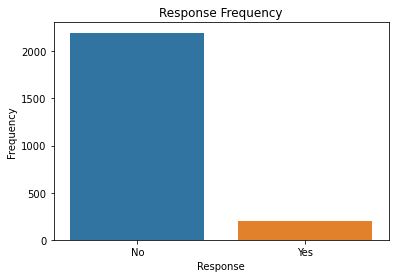

<IPython.core.display.Javascript object>

In [5]:
sns.countplot(x=X_train["Response"]).set(
    title="Response Frequency", xlabel="Response", ylabel="Frequency"
)
X_train["Response"].value_counts(normalize=True)

There is a response rate of 8.46% (No response = 91.54%)

##### Response rate for each of the combinations of RFM categories

In [6]:
# Group By Rcode, Fcode, Mcode, and Response
grouped_df = X_train.groupby(["Rcode", "Fcode", "Mcode"], as_index=False).size()
display(grouped_df.head(5))
grouped_df.shape

,Rcode,Fcode,Mcode,size
0,1,1,2,5
1,1,1,3,10
2,1,1,4,9
3,1,1,5,25
4,1,2,2,3


(48, 4)

<IPython.core.display.Javascript object>

According to the training dataset, there are a total of 48 different combinations of Rcode, Fcode, and Mcode

In [7]:
# Group By Rcode, Fcode, Mcode, and Response
grouped_df = X_train.groupby(
    ["Rcode", "Fcode", "Mcode", "Response"], as_index=False
).size()

# Pivot by Fcode, Rcode, Mcode and display response count
pivoted_df = grouped_df.pivot(
    index="Response", columns=["Rcode", "Fcode", "Mcode"], values="size"
)

# Add total column and rows
summed_df = pivoted_df.copy()
summed_df["Total"] = summed_df.sum(axis=1)
summed_df.loc["Total"] = summed_df.sum()

# Replace NaN values with 0
summed_df = summed_df.fillna(0)

# Add a new Row that calculates Response Rate (Yes count divided by Total count)
summed_df.loc["Response Rate"] = round(summed_df.iloc[1] / summed_df.iloc[2] * 100, 2)

<IPython.core.display.Javascript object>

In [8]:
# Display DataFrame of RFM Response Rate
pd.set_option("max_columns", None)
display(summed_df)
pd.reset_option("max_columns")

Rcode             1                                                         \
Fcode             1                         2                       3        
Mcode             2     3      4     5      2    3     4     5      2    3   
Response                                                                     
No              4.0  10.0   7.00  22.0   2.00  8.0  20.0  18.0    0.0  2.0   
Yes             1.0   0.0   2.00   3.0   1.00  0.0   0.0   2.0    1.0  0.0   
Total           5.0  10.0   9.00  25.0   3.00  8.0  20.0  20.0    1.0  2.0   
Response Rate  20.0   0.0  22.22  12.0  33.33  0.0   0.0  10.0  100.0  0.0   

Rcode                          2                                         \
Fcode                          1                               2          
Mcode             4      5     1      2     3      4      5    2      3   
Response                                                                  
No             19.0  35.00   1.0   6.00  19.0  27.00  24.00  4.0  18.00   
Yes             1.0   9.00   1.0   1.00   1.0   1.00   3.00  0.0   3.00   
Total          20.0  44.00   2.0   7.00  20.0  28.00  27.00  4.0  21.00   
Response Rate   5.0  20.45  50.0  14.29   5.0   3.57  11.11  0.0  14.29   

Rcode                                              3                       \
Fcode                           3                  1                        
Mcode              4      5     3      4     5     1      2      3      4   
Response                                                                    
No             31.00  41.00   2.0  32.00  77.0   6.0  30.00  33.00  80.00   
Yes             3.00   3.00   2.0   3.00  15.0   2.0   2.00   1.00   6.00   
Total          34.00  44.00   4.0  35.00  92.0   8.0  32.00  34.00  86.00   
Response Rate   8.82   6.82  50.0   8.57  16.3  25.0   6.25   2.94   6.98   

Rcode                                                                       4  \
Fcode                      2                            3                   1   
Mcode               5      2      3      4       5      3     4       5     1   
Response                                                                        
No             105.00  13.00  31.00  72.00  103.00  21.00  63.0  185.00  16.0   
Yes              5.00   1.00   3.00   6.00    4.00   1.00   7.0   24.00   0.0   
Total          110.00  14.00  34.00  78.00  107.00  22.00  70.0  209.00  16.0   
Response Rate    4.55   7.14   8.82   7.69    3.74   4.55  10.0   11.48   0.0   

Rcode                                                                    \
Fcode                                            2                        
Mcode              2      3       4       5      2     3      4       5   
Response                                                                  
No             25.00  60.00  104.00  118.00  14.00  52.0  114.0  124.00   
Yes             1.00   7.00    8.00    8.00   1.00   2.0    6.0   15.00   
Total          26.00  67.00  112.00  126.00  15.00  54.0  120.0  139.00   
Response Rate   3.85  10.45    7.14    6.35   6.67   3.7    5.0   10.79   

Rcode                                   Total  
Fcode              3                           
Mcode              3       4       5           
Response                                       
No             18.00  108.00  273.00  2197.00  
Yes             1.00   11.00   25.00   203.00  
Total          19.00  119.00  298.00  2400.00  
Response Rate   5.26    9.24    8.39     8.46

<IPython.core.display.Javascript object>

In [9]:
# Another Display of Response Rate
responseRate = summed_df.loc["Response Rate"]
display(responseRate)

Rcode  Fcode  Mcode
1      1      2         20.00
              3          0.00
              4         22.22
              5         12.00
       2      2         33.33
              3          0.00
              4          0.00
              5         10.00
       3      2        100.00
              3          0.00
              4          5.00
              5         20.45
2      1      1         50.00
              2         14.29
              3          5.00
              4          3.57
              5         11.11
       2      2          0.00
              3         14.29
              4          8.82
              5          6.82
       3      3         50.00
              4          8.57
              5         16.30
3      1      1         25.00
              2          6.25
              3          2.94
              4          6.98
              5          4.55
       2      2          7.14
              3          8.82
              4          7.69
              5     

<IPython.core.display.Javascript object>

The output above shows the RFM response rate (Last column) for all RFM combinations in the training data set

##### Which combinations have response rates in the training data that are above the overall response in the training data?

_Filter data frame with response rates (RMF combinations in training data) higher than the overall training response rate_

In [10]:
# Filtered RFM
transposed_df = summed_df.T
filter_responseRate = transposed_df[transposed_df["Response Rate"] >= 8.46]
filter_responseRate = filter_responseRate[["Response Rate"]]
filter_responseRate = filter_responseRate[:-1]  # Remove last row (total)
filter_responseRate

Response           Response Rate
Rcode Fcode Mcode               
1     1     2              20.00
            4              22.22
            5              12.00
      2     2              33.33
            5              10.00
      3     2             100.00
            5              20.45
2     1     1              50.00
            2              14.29
            5              11.11
      2     3              14.29
            4               8.82
      3     3              50.00
            4               8.57
            5              16.30
3     1     1              25.00
      2     3               8.82
      3     4              10.00
            5              11.48
4     1     3              10.45
      2     5              10.79
      3     4               9.24

<IPython.core.display.Javascript object>

The table above shows the RFM combinations (in the training set) that have a higher response rate than the overall response rate of the training data set.

#### 1.2 Suppose that we decide to send promotional mail only to the “above-average” RFM combinations identified in part 1. Compute the response rate in the validation data using these combinations.

In [11]:
# Create a new Dataframe with the RMF combinations identified in part 1 (higher response rate)
RFMcombinations = list(filter_responseRate.index)
RFMcombinations = pd.DataFrame(RFMcombinations)

# Drop last row (last row is 'total' which is not RFM combo)
RFMcombinations = RFMcombinations[:-1]

# Rename columns
RFMcombinations = RFMcombinations.rename(columns={0: "Rcode", 1: "Fcode", 2: "Mcode"})

<IPython.core.display.Javascript object>

In [12]:
# Display RFM combinations in training data set with response rate >= 8.46
RFMcombinations

,Rcode,Fcode,Mcode
0,1,1,2
1,1,1,4
2,1,1,5
3,1,2,2
4,1,2,5
5,1,3,2
6,1,3,5
7,2,1,1
8,2,1,2
9,2,1,5


<IPython.core.display.Javascript object>

All RFM combinations in training data set (output above) that had a higher response rate than the overall response rate in training data

In [13]:
# Subset validation dataset containing the same RFM combinations found in part 1
validData_subset_df = X_valid.merge(
    RFMcombinations, on=["Rcode", "Fcode", "Mcode"], how="inner"
).dropna()

<IPython.core.display.Javascript object>

In [14]:
# Group By Rcode, Fcode, Mcode, and Response
grouped_df = validData_subset_df.groupby(
    ["Rcode", "Fcode", "Mcode", "Response"], as_index=False
).size()

# Pivot by Fcode, Rcode, Mcode and display response count
pivoted_df = grouped_df.pivot(
    index="Response", columns=["Rcode", "Fcode", "Mcode"], values="size"
)

# Add total column and rows
summed_df = pivoted_df.copy()
summed_df["Total"] = summed_df.sum(axis=1)
summed_df.loc["Total"] = summed_df.sum()

# Replace NaN values with 0
summed_df = summed_df.fillna(0)

# Add a new Row that calculates Response Rate (Yes count divided by Total count)
summed_df.loc["Response Rate"] = round(summed_df.iloc[1] / summed_df.iloc[2] * 100, 2)

<IPython.core.display.Javascript object>

In [15]:
# Display DataFrame of RFM Response Rate
pd.set_option("max_columns", None)
display(summed_df)
pd.reset_option("max_columns")

Rcode            1                                       2                \
Fcode            1                   2            3      1                 
Mcode            2      4      5     2      5     5      1      2      5   
Response                                                                   
No             1.0  13.00  14.00   1.0  18.00  35.0   2.00   5.00  19.00   
Yes            0.0   3.00   1.00   1.0   1.00   5.0   1.00   2.00   3.00   
Total          1.0  16.00  15.00   2.0  19.00  40.0   3.00   7.00  22.00   
Response Rate  0.0  18.75   6.67  50.0   5.26  12.5  33.33  28.57  13.64   

Rcode                                             3                       \
Fcode              2           3                  1     2      3           
Mcode              3      4    3      4      5    1     3      4       5   
Response                                                                   
No             15.00  25.00  4.0  26.00  47.00  6.0  24.0  49.00  120.00   
Yes             1.00   3.00  0.0   6.00   7.00  0.0   1.0   3.00   28.00   
Total          16.00  28.00  4.0  32.00  54.00  6.0  25.0  52.00  148.00   
Response Rate   6.25  10.71  0.0  18.75  12.96  0.0   4.0   5.77   18.92   

Rcode             4          Total  
Fcode             1      2          
Mcode             3      5          
Response                            
No             37.0   98.0  559.00  
Yes             5.0    2.0   73.00  
Total          42.0  100.0  632.00  
Response Rate  11.9    2.0   11.55

<IPython.core.display.Javascript object>

In [16]:
# Different display of RFM combinations in validation set and their response rate
transposed_df = summed_df.T
transposed_df = transposed_df["Response Rate"]
transposed_df = transposed_df[:-1]
display(transposed_df)

Rcode  Fcode  Mcode
1      1      2         0.00
              4        18.75
              5         6.67
       2      2        50.00
              5         5.26
       3      5        12.50
2      1      1        33.33
              2        28.57
              5        13.64
       2      3         6.25
              4        10.71
       3      3         0.00
              4        18.75
              5        12.96
3      1      1         0.00
       2      3         4.00
       3      4         5.77
              5        18.92
4      1      3        11.90
       2      5         2.00
Name: Response Rate, dtype: float64

<IPython.core.display.Javascript object>

After identifying the RMF combinations, a subset of the validation set was created with the same combinations identified in part 1 where the response rate of the training data set is higher than the overall data set. The tables above show the response rate of the validation dataset (with the same RMF combinations found in part 1). 

###  2. The k-NN technique can be used to create segments based on product proximity to similar products of the products offered as well as the propensity to purchase (as measured by the RFM variables). For The Art History of Florence, a possible segmentation by product proximity could be created using the following variables:
- R: recency—months since last purchase
- F: frequency—total number of past purchases
- M: monetary—total money (in dollars) spent on books
- FirstPurch: months since first purchase
- RelatedPurch: total number of past purchases of related books (i.e., sum of purchases from the art and geography categories and of titles Secrets of Italian Cooking, Historical Atlas of Italy, and Italian Art)

_Set Predictors_

In [17]:
predictors = ["R", "F", "M", "FirstPurch", "Related Purchase"]
X_train = X_train.loc[:, predictors]
X_valid = X_valid.loc[:, predictors]

<IPython.core.display.Javascript object>

_Normalize Variables_

In [18]:
# Normalize
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

# Transform
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

# Create Dataframe with new column labels
X_train = pd.DataFrame(
    data=X_train, columns=["zR", "zF", "zM", "zFirstPurch", "zRelatedPurch"]
)
display(X_train)
X_valid = pd.DataFrame(
    data=X_valid, columns=["zR", "zF", "zM", "zFirstPurch", "zRelatedPurch"]
)
display(X_valid)

# Reset index to match with predictor dataframe index
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)

,zR,zF,zM,zFirstPurch,zRelatedPurch
0,-0.436452,0.638995,-0.974024,0.200474,0.933548
1,-0.930315,0.057650,-1.273797,-0.132225,-0.723026
2,-1.177246,1.220339,0.225067,-0.243124,-0.723026
3,-0.436452,1.511012,-0.454418,0.200474,-0.723026
4,-0.436452,-0.814367,0.424915,-0.908521,0.105261
...,...,...,...,...,...
2395,-0.189520,0.929667,0.025218,0.089574,-0.723026
2396,1.045138,-0.523695,0.544825,0.200474,0.105261
2397,-1.424178,-0.814367,0.924537,-1.352119,0.105261
2398,-0.930315,-0.814367,-1.333752,-1.130320,-0.723026


,zR,zF,zM,zFirstPurch,zRelatedPurch
0,0.304343,-0.523695,0.594787,-0.354024,0.105261
1,1.045138,1.801684,-0.374479,1.974866,-0.723026
2,-0.189520,-0.814367,-0.194615,-0.797622,0.933548
3,-0.189520,-0.814367,-1.813388,-0.797622,-0.723026
4,-1.424178,0.057650,1.194332,-0.464923,-0.723026
...,...,...,...,...,...
1595,0.057412,2.092356,0.364961,2.862063,2.590122
1596,0.057412,2.383029,2.123628,2.862063,0.933548
1597,-0.930315,1.220339,-0.494388,0.422273,0.105261
1598,0.057412,1.801684,2.353454,1.863967,0.933548


<IPython.core.display.Javascript object>

#### 2.1 Use the k-NN approach with uniform weights to classify cases with k = 1, 2, ..., 11, using Florence as the outcome variable. Based on the validation set, find the best k. Remember to normalize all five variables. Create a lift curve for the best k model, and report the expected lift for an equal number of customers from the validation dataset

In [19]:
# Train a classifier for different values of k
auc_score = []
results = []
for k in range(1, 12):
    knn = KNeighborsClassifier(n_neighbors=k, weights="uniform").fit(X_train, y_train)

    y_pred_proba = knn.predict_proba(X_valid)[:, 1]

    auc_score.append({"k": k, "AUC": roc_auc_score(y_valid, y_pred_proba)})

    results.append({"k": k, "accuracy": accuracy_score(y_valid, knn.predict(X_valid))})

<IPython.core.display.Javascript object>

accuracy by k


,k,accuracy
0,1,0.845625
1,2,0.910000
2,3,0.891250
3,4,0.907500
4,5,0.905000
5,6,0.910000
6,7,0.907500
7,8,0.910625
8,9,0.909375
9,10,0.913750


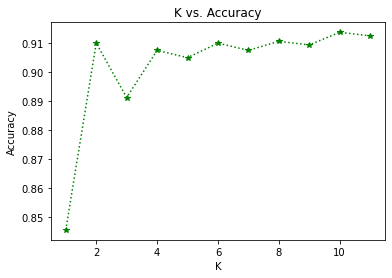

<IPython.core.display.Javascript object>

In [20]:
# Convert results to a pandas data frame
results = pd.DataFrame(results)
print("accuracy by k")
display(results)

# show accuracy by k
plt.plot(results.k, results.accuracy, linestyle=":", c="green", marker="*")
plt.title("K vs. Accuracy")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()

AUC score by K


,k,AUC
0,1,0.502124
1,2,0.497636
2,3,0.506816
3,4,0.513771
4,5,0.524705
5,6,0.510970
6,7,0.530646
7,8,0.542452
8,9,0.545221
9,10,0.556069


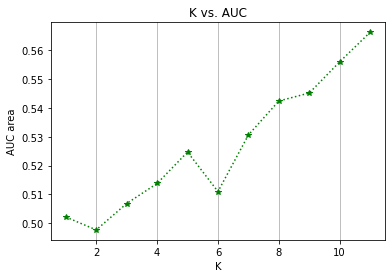

<IPython.core.display.Javascript object>

In [21]:
# Convert AUC scores to a pandas data frame
auc_score = pd.DataFrame(auc_score)
print("AUC score by K")
display(auc_score)

# show AUC by k
plt.plot(auc_score.k, auc_score.AUC, linestyle=":", c="green", marker="*")
plt.title("K vs. AUC")
plt.xlabel("K")
plt.ylabel("AUC area")
plt.gca().xaxis.grid(True)
plt.show()

k=10 had the best accuracy score & k=11 had the best auc score. Both k values were also the second best choice in the other metric test. However, the jump between 10 and 11 is bigger on the AUC curve than the accuracy test, so I will choose the best metric score of **k=11**. In addition, a smaller K value (K=3) can be used (if needed) since the difference of scores from K=3 to K=11 are insignificant. 

_Gain analysis_

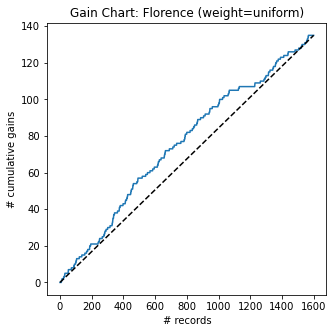

<IPython.core.display.Javascript object>

In [22]:
# Create Model
KNN = KNeighborsClassifier(n_neighbors=11, weights="uniform").fit(X_train, y_train)

KNN_proba = KNN.predict_proba(X_valid)
KNN_result = pd.DataFrame(
    {
        "actual": y_valid,
        "p(0)": [p[0] for p in KNN_proba],
        "p(1)": [p[1] for p in KNN_proba],
        "predicted": KNN.predict(X_valid),
    }
)
KNN_result = KNN_result.sort_values(by=["p(1)"], ascending=False)

# Gain Chart
ax0 = gainsChart(KNN_result.actual, figsize=[5, 5])
ax0.set_title("Gain Chart: Florence (weight=uniform)")
plt.show()

The gains curve asses the perfomance of the model and compares it with a baseline(random pick). The gains chart also shows the percentage of targets reached when considering a certain percentain of the population with the highest probability to the target according the model. The gain chart above shows how the KNN model outperforms the random model. For instance, if the model selected 700 records, the model is would be right about 75 records as opposed to the random model where it would be right for about 55 records. Therefore, the model outperforms the random model. 

_Lift analysis_

<AxesSubplot:title={'center':'Decile Lift Chart'}, xlabel='Percentile', ylabel='Lift'>

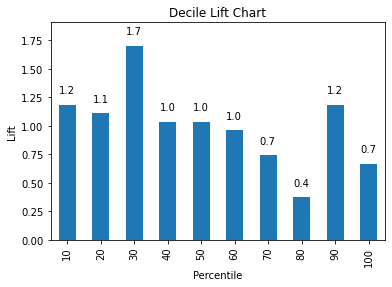

<IPython.core.display.Javascript object>

In [23]:
liftChart(KNN_result.actual, labelBars=True)

In [24]:
# Confusion Matrix
classificationSummary(KNN_result.actual, KNN_result.predicted)

Confusion Matrix (Accuracy 0.9125)

       Prediction
Actual    0    1
     0 1460    5
     1  135    0


<IPython.core.display.Javascript object>

In decile analysis, the ideal solution would be a staircase effect where the biggest bar is on the left and decrease towards the right. The decile lift chart above indicates that the model is not doing a sufficient job of predicting actual responses. This can be supported further by the confusion matrix. Moreover, the lift chart also shows how much better the model is performing than the random model. For instance, at the 30 percentile, the model yields 1.7x as many 1's (0/1) as would a random selection at the top 30 percentile. 

#### 2.2 The k-NN prediction algorithm gives a numerical value, which is a weighted average of the values of the Florence variable for the k-NN with weights that are inversely proportional to distance. Using the best k that you calculated above with k-NN classification, now run a model with k-NN prediction and compute a lift curve for the validation data. Use all 5 predictors and normalized data. What is the range within which a prediction will fall? How does this result compare to the output you get with the k-NN classification? 

_Gain analysis_

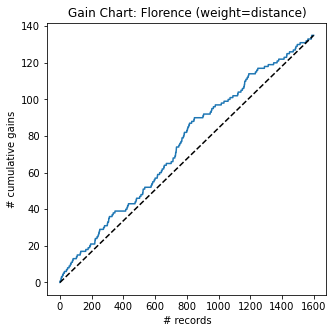

<IPython.core.display.Javascript object>

In [25]:
# Create Model
KNN_dist = KNeighborsClassifier(n_neighbors=11, weights="distance").fit(
    X_train, y_train
)

KNN_proba_dist = KNN_dist.predict_proba(X_valid)
KNN_result_dist = pd.DataFrame(
    {
        "actual": y_valid,
        "p(0)": [p[0] for p in KNN_proba_dist],
        "p(1)": [p[1] for p in KNN_proba_dist],
        "predicted": KNN_dist.predict(X_valid),
    }
)
KNN_result_dist = KNN_result_dist.sort_values(by=["p(1)"], ascending=False)

# Gain Chart
ax0 = gainsChart(KNN_result_dist.actual, figsize=[5, 5])
ax0.set_title("Gain Chart: Florence (weight=distance)")
plt.show()

Similar explanation given for the gain chat with 'weight=uniform'. Both models are slightly better than the random baseline model. 

_Lift analysis_

<AxesSubplot:title={'center':'Decile Lift Chart'}, xlabel='Percentile', ylabel='Lift'>

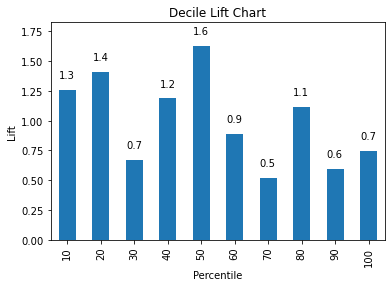

<IPython.core.display.Javascript object>

In [26]:
# Implement Decile Lift Chart
liftChart(KNN_result_dist.actual, labelBars=True)

In [27]:
# Confusion Matrix
classificationSummary(KNN_result_dist.actual, KNN_result_dist.predicted)

Confusion Matrix (Accuracy 0.9062)

       Prediction
Actual    0    1
     0 1445   20
     1  130    5


<IPython.core.display.Javascript object>

Similar to the previous explanation of the lift chart. However, for this model, the 50th percentile has the highest lift at 1.6x. 

_Compare Gain Charts_

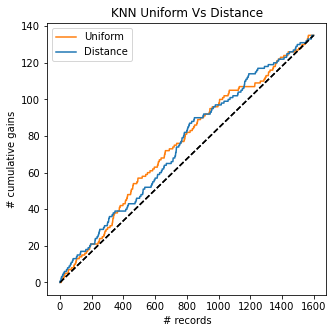


Uniform - AIC 656.8169292652433

Distance - AIC 767.2055236443653


<IPython.core.display.Javascript object>

In [28]:
ax1 = gainsChart(KNN_result.actual, label="Uniform", color="C1", figsize=[5, 5])
ax1 = gainsChart(KNN_result_dist.actual, label="Distance", color="C0", ax=ax1)
ax1.legend()
ax1.set_title("KNN Uniform Vs Distance")
plt.show()

print(
    "\nUniform - AIC",
    AIC_score(y_valid, KNN.predict(X_valid), df=len(X_train.columns) + 1),
)
print(
    "\nDistance - AIC",
    AIC_score(y_valid, KNN_dist.predict(X_valid), df=len(X_train.columns) + 1),
)

Both models predicts in the range of 0 or 1. Comparing the two graphs, the uniform weight performs better with a fewer percentage of records while the distance weight performs slightly better with higher percentage of records. In addition, mode of the uniform curve extends past the distance curve indicating the uniform model that predicts more accurately than distance model. Furthermore, akaike information criterion (AIC) is a method to evaluate how well a model fits the data it was generated from. The best-fit model according to AIC is the one that explains the greatest amount of variation using the fewest possible independent variables. A lower AIC value indicates a better fit, which is the case for the uniform weight. In conclusion, the KNN (weight=uniform) model outperformed the KNN (weight=distance) model.

### 3. The logistic regression model offers a powerful method for modeling response because it yields well-defined purchase probabilities. The model is especially attractive in consumer-choice settings because it can be derived from the random utility theory of consumer behavior. 

#### 3.1 Use the training set data of 2400 records to construct two logistic regression models with Florence as the outcome variable and each of the following sets of predictors:

- **The full set of 16 predictors in the dataset**

In [29]:
# 16 predictors
predictors = [
    "Gender",
    "M",
    "R",
    "F",
    "FirstPurch",
    "ChildBks",
    "YouthBks",
    "CookBks",
    "DoItYBks",
    "RefBks",
    "ArtBks",
    "GeogBks",
    "ItalCook",
    "ItalAtlas",
    "ItalArt",
    "Related Purchase",
]

X_train, X_valid, y_train, y_valid = train_test_split(
    club_df.drop("Florence", axis=1),
    club_df["Florence"],
    test_size=0.4,
    stratify=club_df["Florence"],
    random_state=1,
)

X_train = X_train.loc[:, predictors]
X_valid = X_valid.loc[:, predictors]

# Normalize
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

# Transform
X_train_F = scaler.transform(X_train)
X_valid_F = scaler.transform(X_valid)

# Create Dataframe with new column labels
X_train_F = pd.DataFrame(
    data=X_train_F,
    columns=[
        "zGender",
        "zM",
        "zR",
        "zF",
        "zFirstPurch",
        "zChildBks",
        "zYouthBks",
        "zCookBks",
        "zDoItYBks",
        "zRefBks",
        "zArtBks",
        "zGeogBks",
        "zItalCook",
        "zItalAtlas",
        "zItalArt",
        "zRelated Purchase",
    ],
)
X_valid_F = pd.DataFrame(
    data=X_valid_F,
    columns=[
        "zGender",
        "zM",
        "zR",
        "zF",
        "zFirstPurch",
        "zChildBks",
        "zYouthBks",
        "zCookBks",
        "zDoItYBks",
        "zRefBks",
        "zArtBks",
        "zGeogBks",
        "zItalCook",
        "zItalAtlas",
        "zItalArt",
        "zRelated Purchase",
    ],
)

# Reset index to match with predictor dataframe index
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)

# Logistic Regression Model
logit_full = LogisticRegression(random_state=1)
logit_full.fit(X_train_F, y_train)
pd.set_option("display.width", 95)
pd.set_option("display.precision", 3)
pd.set_option("display.max_columns", 33)
# Print intercept
print("intercept ", logit_full.intercept_[0], "\n")

# Display coefficients of predictors
print(pd.DataFrame({"coeff": logit_full.coef_[0]}, index=X_train_F.columns).transpose())
display(
    pd.DataFrame({"coeff": logit_full.coef_[0]}, index=X_train_F.columns).transpose()
)

pd.reset_option("display.width")
pd.reset_option("display.precision")
pd.reset_option("display.max_columns")

# Show AIC Score
print(
    "\nAIC",
    AIC_score(y_valid, logit_full.predict(X_valid_F), df=len(X_train_F.columns) + 1),
)

intercept  -2.53521122124618 

       zGender     zM    zR     zF  zFirstPurch  zChildBks  zYouthBks  zCookBks  zDoItYBks  \
coeff     -0.3 -0.041 -0.06  0.777        0.075     -0.267     -0.079    -0.387     -0.122   

       zRefBks  zArtBks  zGeogBks  zItalCook  zItalAtlas  zItalArt  zRelated Purchase  
coeff   -0.213    0.181     0.004      0.006      -0.015     0.097              0.107  


,zGender,zM,zR,zF,zFirstPurch,zChildBks,zYouthBks,zCookBks,zDoItYBks,zRefBks,zArtBks,zGeogBks,zItalCook,zItalAtlas,zItalArt,zRelated Purchase
coeff,-0.3,-0.041,-0.06,0.777,0.075,-0.267,-0.079,-0.387,-0.122,-0.213,0.181,0.004,0.006,-0.015,0.097,0.107



AIC 596.7476582451623


<IPython.core.display.Javascript object>

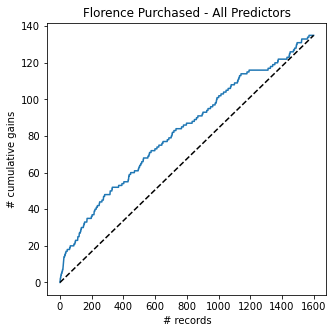

<IPython.core.display.Javascript object>

In [30]:
logit_full_proba = logit_full.predict_proba(X_valid_F)
full_result = pd.DataFrame(
    {
        "actual": y_valid,
        "p(0)": [p[0] for p in logit_full_proba],
        "p(1)": [p[1] for p in logit_full_proba],
        "predicted": logit_full.predict(X_valid_F),
    }
)
full_result = full_result.sort_values(by=["p(1)"], ascending=False)
ax0 = gainsChart(full_result.actual, figsize=[5, 5])
ax0.set_title("Florence Purchased - All Predictors")
plt.show()

In [31]:
classificationSummary(full_result.actual, full_result.predicted)

Confusion Matrix (Accuracy 0.9169)

       Prediction
Actual    0    1
     0 1465    0
     1  133    2


<IPython.core.display.Javascript object>

- **A subset of predictors that you judge to be the best**

_Remove Highly Correlated Features_

In [32]:
# Correlation Matrix
correlated_features = set()
correlation_matrix = club_df.loc[:, predictors].corr()

# Correlation Matrix Visualization
cmap = cmap = sns.diverging_palette(5, 250, as_cmap=True)
display(correlation_matrix.style.background_gradient(cmap, axis=1))

# Filter Highly Correlated Variables
threshold = 0.75

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print(
    "Number of correlation value greater than .75 with at least 1 other column: ",
    len(correlated_features),
)
print("Correlated features include: ", correlated_features)

,Gender,M,R,F,FirstPurch,ChildBks,YouthBks,CookBks,DoItYBks,RefBks,ArtBks,GeogBks,ItalCook,ItalAtlas,ItalArt,Related Purchase
Gender,1.000000,-0.011231,0.004569,0.001252,0.004645,-0.003756,0.010938,0.020793,-0.006701,-0.035448,-0.024078,0.018999,-0.035474,-0.011931,0.000190,-0.013375
M,-0.011231,1.000000,0.007779,0.509035,0.434561,0.358133,0.286340,0.369060,0.275389,0.250838,0.074617,0.348304,0.074979,0.141313,0.135598,0.322495
R,0.004569,0.007779,1.000000,0.002797,0.448581,0.138025,0.068426,0.155865,0.105360,0.110035,0.033409,0.064075,0.055342,0.001067,0.060360,0.084040
F,0.001252,0.509035,0.002797,1.000000,0.832149,0.676616,0.538481,0.716067,0.565413,0.483482,0.169759,0.375900,0.136091,0.254919,0.237463,0.443442
FirstPurch,0.004645,0.434561,0.448581,0.832149,1.000000,0.629666,0.479589,0.684791,0.536704,0.456534,0.163447,0.344532,0.145914,0.207257,0.231697,0.414850
ChildBks,-0.003756,0.358133,0.138025,0.676616,0.629666,1.000000,0.280748,0.402993,0.314880,0.269048,0.075103,0.223254,0.115789,0.140590,0.175468,0.266057
YouthBks,0.010938,0.286340,0.068426,0.538481,0.479589,0.280748,1.000000,0.327690,0.236058,0.189312,0.078008,0.220819,0.071364,0.129959,0.122680,0.240666
CookBks,0.020793,0.369060,0.155865,0.716067,0.684791,0.402993,0.327690,1.000000,0.333651,0.294996,0.078949,0.234097,0.156987,0.176720,0.167704,0.292461
DoItYBks,-0.006701,0.275389,0.105360,0.565413,0.536704,0.314880,0.236058,0.333651,1.000000,0.208651,0.083795,0.171084,0.068145,0.130995,0.144674,0.216182
RefBks,-0.035448,0.250838,0.110035,0.483482,0.456534,0.269048,0.189312,0.294996,0.208651,1.000000,0.115375,0.168757,0.039064,0.228556,0.113917,0.232641


Number of correlation value greater than .75 with at least 1 other column:  1
Correlated features include:  {'FirstPurch'}


<IPython.core.display.Javascript object>

FirstPurch is removed due to high correlation. Other variables excluded were determined from the coefficients of the full logistic regression. Anything under |0.1| coefficient were removed. Therefore the predictors used in the reduced dataset include: **'Gender', 'F', 'ChildBks', 'CookBks', 'RefBks', 'ArtBks', 'DoItYBks', 'Related Purchase'**

_Reduce Predictors, Normalize, Model, Results_

In [33]:
# Reduced predictors
predictors = [
    "Gender",
    "F",
    "ChildBks",
    "CookBks",
    "RefBks",
    "ArtBks",
    "DoItYBks",
    "Related Purchase",
]

# Recreating test/train split pre-normalized
X_train, X_valid, y_train, y_valid = train_test_split(
    club_df.drop("Florence", axis=1),
    club_df["Florence"],
    test_size=0.4,
    stratify=club_df["Florence"],
    random_state=1,
)

# Include reduced features
X_train_clean = X_train.loc[:, predictors]
X_valid_clean = X_valid.loc[:, predictors]

# Reset Index
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)

# Normalize
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_clean)

# Transform
X_train = scaler.transform(X_train_clean)
X_valid = scaler.transform(X_valid_clean)


# Logistic Regression Model
# logit_red = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_red = LogisticRegression(random_state=1)
logit_red.fit(X_train, y_train)

pd.set_option("display.width", 95)
pd.set_option("display.precision", 3)
pd.set_option("display.max_columns", 33)
# Print intercept
print("intercept ", logit_full.intercept_[0], "\n")

# Display coefficients of predictors
print(
    pd.DataFrame({"coeff": logit_red.coef_[0]}, index=X_train_clean.columns).transpose()
)
display(
    pd.DataFrame({"coeff": logit_red.coef_[0]}, index=X_train_clean.columns).transpose()
)

pd.reset_option("display.width")
pd.reset_option("display.precision")
pd.reset_option("display.max_columns")

# Show AIC Score
print(
    "\nAIC",
    AIC_score(y_valid, logit_red.predict(X_valid), df=len(X_train_clean.columns) + 1),
)

intercept  -2.53521122124618 

       Gender      F  ChildBks  CookBks  RefBks  ArtBks  DoItYBks  Related Purchase
coeff  -0.298  0.752    -0.248   -0.378  -0.208   0.167    -0.112             0.153


,Gender,F,ChildBks,CookBks,RefBks,ArtBks,DoItYBks,Related Purchase
coeff,-0.298,0.752,-0.248,-0.378,-0.208,0.167,-0.112,0.153



AIC 580.7476582451623


<IPython.core.display.Javascript object>

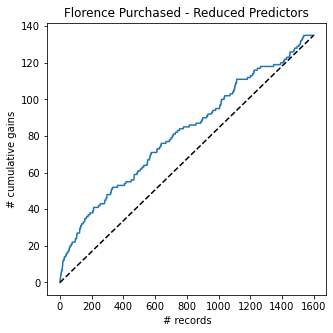

<IPython.core.display.Javascript object>

In [34]:
logit_reg_proba = logit_red.predict_proba(X_valid)
red_result = pd.DataFrame(
    {
        "actual": y_valid,
        "p(0)": [p[0] for p in logit_reg_proba],
        "p(1)": [p[1] for p in logit_reg_proba],
        "predicted": logit_red.predict(X_valid),
    }
)
red_result = red_result.sort_values(by=["p(1)"], ascending=False)
ax0 = gainsChart(red_result.actual, figsize=[5, 5])
ax0.set_title("Florence Purchased - Reduced Predictors")
plt.show()

In [35]:
classificationSummary(red_result.actual, red_result.predicted)

Confusion Matrix (Accuracy 0.9169)

       Prediction
Actual    0    1
     0 1465    0
     1  133    2


<IPython.core.display.Javascript object>

_Compare Gain chart for Both Models_

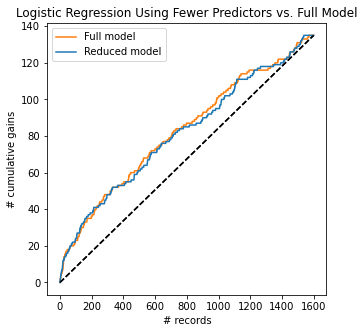


Full Predictor AUC area =  0.6231146504866641

Reduced Predictor AUC area =  0.6151864492478827

Full Predictor AIC =  596.7476582451623

Reduced Predictor AIC =  580.7476582451623


<IPython.core.display.Javascript object>

In [36]:
ax = gainsChart(full_result.actual, label="Full model", color="C1", figsize=[5, 5])
ax = gainsChart(red_result.actual, label="Reduced model", color="C0", ax=ax)
ax.legend()
ax.set_title("Logistic Regression Using Fewer Predictors vs. Full Model")
plt.show()

print("\nFull Predictor AUC area = ", roc_auc_score(y_valid, logit_full_proba[:, 1]))
print("\nReduced Predictor AUC area = ", roc_auc_score(y_valid, logit_reg_proba[:, 1]))
print(
    "\nFull Predictor AIC = ",
    AIC_score(y_valid, logit_full.predict(X_valid_F), df=len(X_train_F.columns) + 1),
)
print(
    "\nReduced Predictor AIC = ",
    AIC_score(y_valid, logit_red.predict(X_valid), df=len(X_train_clean.columns) + 1),
)

The gains curve indicates the logistic regression models outperforms the random model. From the gain curve, both models have very similar gains. In addition, the AUC scores were calculated and both yielded very similar results as well. However, the AIC of the Reduced dataset is lower than the AIC of the Full Predictor dataset. Therefore, it is concluded that the reduced model of 8 predictors is a better choice than the model with 16 predictors because the reduced model is a better fit and decreases the chance of overfitting the model. 

#### 3.2 If the cutoff criterion for a campaign is a 30% likelihood of a purchase, find the customers in the validation data that would be targeted and count the number of buyers in this set

##### Full Model
_Both models were evaluated, but explanations will be provided on the 'Reduced' model since it was chosen to be the better model in 3.1._

In [37]:
# Getting the prediction probability of class 1
Pred_Prob = pd.DataFrame(
    data=logit_full.predict_proba(X_valid_F)[:, 1], columns=["Prob"]
)
Pred_Prob["Florence"] = y_valid

# Filter Prob above .3
cutoff_Pred_Prob = Pred_Prob[Pred_Prob["Prob"] >= 0.30]
display(cutoff_Pred_Prob)  # Customers in Validation Set that would be targeted

print("Number of customers within the 30% cutoff criterion:", len(cutoff_Pred_Prob))
print(
    "Total number of actual buyers in the cutoff set:",
    cutoff_Pred_Prob["Florence"].sum(),
)
print(
    "Percentage of buyers:",
    cutoff_Pred_Prob["Florence"].sum() / len(cutoff_Pred_Prob) * 100,
)

,Prob,Florence
93,0.328464,1
129,0.326972,1
203,0.348372,0
223,0.328578,1
271,0.467076,1
310,0.369479,0
357,0.345792,1
361,0.376668,0
491,0.404259,1
621,0.529770,1


Number of customers within the 30% cutoff criterion: 30
Total number of actual buyers in the cutoff set: 15
Percentage of buyers: 50.0


<IPython.core.display.Javascript object>

In [38]:
# Getting the numbers of customers and buyers for a range of cutoff criterion
Pred_Prob = pd.DataFrame(
    data=logit_full.predict_proba(X_valid_F)[:, 1], columns=["Prob"]
)
Pred_Prob["Florence"] = y_valid
cutoff = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
results = []
for c in cutoff:
    cutoff_Pred_Prob = Pred_Prob[Pred_Prob["Prob"] >= c]
    results.append(
        {
            "Cutoff Percent": c,
            "Total Customers": len(cutoff_Pred_Prob),
            "Buyers": cutoff_Pred_Prob["Florence"].sum(),
            "Percentage of Buyers": cutoff_Pred_Prob["Florence"].sum()
            / len(cutoff_Pred_Prob)
            * 100,
        }
    )
results = pd.DataFrame(results)
display(results)

,Cutoff Percent,Total Customers,Buyers,Percentage of Buyers
0,0.10,394,54,13.705584
1,0.15,172,35,20.348837
2,0.20,92,21,22.826087
3,0.25,42,17,40.476190
4,0.30,30,15,50.000000
5,0.35,13,6,46.153846
6,0.40,9,5,55.555556
7,0.45,5,3,60.000000
8,0.50,2,2,100.000000
9,0.55,1,1,100.000000


<IPython.core.display.Javascript object>

In [39]:
# Extended/Variation of Cutoff Criterion anaylsis
Pred_Prob = pd.DataFrame(
    data=logit_full.predict_proba(X_valid_F)[:, 1], columns=["Prob"]
)
Pred_Prob["Actual"] = y_valid
cutoff = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
results = []
for c in cutoff:
    predicted = [1 if i > c else 0 for i in Pred_Prob.Prob]
    Pred_Prob["Cutoff Prediction"] = predicted
    cutoff_Pred_Prob = Pred_Prob[Pred_Prob["Prob"] >= c]
    results.append(
        {
            "Cutoff Percent": c,
            "Total Number of Actual Buyers in Validation Set": Pred_Prob[
                "Actual"
            ].sum(),
            "Actual Percentage of Buyers in Validation Set": round(
                Pred_Prob["Actual"].sum() / len(Pred_Prob) * 100, 2
            ),
            "Number of Predicted Customers (Prob>Cutoff Criterion)": Pred_Prob[
                "Cutoff Prediction"
            ].sum(),
            "Percentage of Predicted Customers in Validation Set ": round(
                Pred_Prob["Cutoff Prediction"].sum() / len(Pred_Prob) * 100, 2
            ),
            "Actual Buyers among Predicted Customers": cutoff_Pred_Prob["Actual"].sum(),
            "Percentage of Buyers among Predicted Customers": round(
                cutoff_Pred_Prob["Actual"].sum() / len(cutoff_Pred_Prob) * 100, 2
            ),
        }
    )
results = pd.DataFrame(results)
display(results)

,Cutoff Percent,Total Number of Actual Buyers in Validation Set,Actual Percentage of Buyers in Validation Set,Number of Predicted Customers (Prob>Cutoff Criterion),Percentage of Predicted Customers in Validation Set,Actual Buyers among Predicted Customers,Percentage of Buyers among Predicted Customers
0,0.10,135,8.44,394,24.62,54,13.71
1,0.15,135,8.44,172,10.75,35,20.35
2,0.20,135,8.44,92,5.75,21,22.83
3,0.25,135,8.44,42,2.62,17,40.48
4,0.30,135,8.44,30,1.88,15,50.00
5,0.35,135,8.44,13,0.81,6,46.15
6,0.40,135,8.44,9,0.56,5,55.56
7,0.45,135,8.44,5,0.31,3,60.00
8,0.50,135,8.44,2,0.12,2,100.00
9,0.55,135,8.44,1,0.06,1,100.00


<IPython.core.display.Javascript object>

##### Reduced Model

In [40]:
# Getting the prediction probability of class 1
Pred_Prob = pd.DataFrame(data=logit_red.predict_proba(X_valid)[:, 1], columns=["Prob"])
Pred_Prob["Florence"] = y_valid

# Filter Prob above .3
cutoff_Pred_Prob = Pred_Prob[Pred_Prob["Prob"] >= 0.30]
display(cutoff_Pred_Prob)  # Customers in Validation Set that would be targeted

print("Number of customers within the 30% cutoff criterion:", len(cutoff_Pred_Prob))
print(
    "Total number of actual buyers in the cutoff set:",
    cutoff_Pred_Prob["Florence"].sum(),
)
print(
    "Percentage of buyers:",
    cutoff_Pred_Prob["Florence"].sum() / len(cutoff_Pred_Prob) * 100,
)

,Prob,Florence
129,0.331853,1
203,0.308588,0
271,0.513701,1
310,0.354712,0
357,0.341375,1
361,0.334900,0
491,0.439214,1
621,0.555491,1
676,0.320484,1
706,0.334669,1


Number of customers within the 30% cutoff criterion: 23
Total number of actual buyers in the cutoff set: 12
Percentage of buyers: 52.17391304347826


<IPython.core.display.Javascript object>

The table above shows the number of customers witha cutoff criterion of 30% likelihood of a purchase. In addition, the output indicates how many of those customers were actual buyers. In short, there are 23 customers that fit within the cutoff criterion, and among those customers, there are 12 of them who are actually buyers. Therefore, if you target the likelihood of purchase cutoff criterion at 30%, then approximately 52% of the people targeted will purchase _The Art History of Florence_.

In [41]:
# Getting the numbers of customers and buyers for a range of cutoff criterion
Pred_Prob = pd.DataFrame(data=logit_red.predict_proba(X_valid)[:, 1], columns=["Prob"])
Pred_Prob["Florence"] = y_valid
cutoff = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
results = []
for c in cutoff:
    cutoff_Pred_Prob = Pred_Prob[Pred_Prob["Prob"] >= c]
    results.append(
        {
            "Cutoff Percent": c,
            "Total Customers": len(cutoff_Pred_Prob),
            "Buyers": cutoff_Pred_Prob["Florence"].sum(),
            "Percentage of Buyers": cutoff_Pred_Prob["Florence"].sum()
            / len(cutoff_Pred_Prob)
            * 100,
        }
    )
results = pd.DataFrame(results)
display(results)

,Cutoff Percent,Total Customers,Buyers,Percentage of Buyers
0,0.10,413,54,13.075061
1,0.15,158,35,22.151899
2,0.20,84,22,26.190476
3,0.25,43,16,37.209302
4,0.30,23,12,52.173913
5,0.35,10,6,60.000000
6,0.40,7,5,71.428571
7,0.45,4,3,75.000000
8,0.50,2,2,100.000000
9,0.55,1,1,100.000000


<IPython.core.display.Javascript object>

Additionally, the same analysis is provided with varying cutoff percentages. Depending on the budget or goal, different cutoff percentages can be determined. For example, would it better to target a lower amount of customers with a higher response rate or larger customers of people with a lower response rate.

In [42]:
# Extended/Variation of Cutoff Criterion anaylsis
Pred_Prob = pd.DataFrame(data=logit_red.predict_proba(X_valid)[:, 1], columns=["Prob"])
Pred_Prob["Actual"] = y_valid
cutoff = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
results = []
for c in cutoff:
    predicted = [1 if i > c else 0 for i in Pred_Prob.Prob]
    Pred_Prob["Cutoff Prediction"] = predicted
    cutoff_Pred_Prob = Pred_Prob[Pred_Prob["Prob"] >= c]
    results.append(
        {
            "Cutoff Percent": c,
            "Total Number of Actual Buyers in Validation Set": Pred_Prob[
                "Actual"
            ].sum(),
            "Actual Percentage of Buyers in Validation Set": round(
                Pred_Prob["Actual"].sum() / len(Pred_Prob) * 100, 2
            ),
            "Number of Predicted Customers (Prob>Cutoff Criterion)": Pred_Prob[
                "Cutoff Prediction"
            ].sum(),
            "Percentage of Predicted Customers in Validation Set ": round(
                Pred_Prob["Cutoff Prediction"].sum() / len(Pred_Prob) * 100, 2
            ),
            "Actual Buyers among Predicted Customers": cutoff_Pred_Prob["Actual"].sum(),
            "Percentage of Buyers among Predicted Customers": round(
                cutoff_Pred_Prob["Actual"].sum() / len(cutoff_Pred_Prob) * 100, 2
            ),
        }
    )
results = pd.DataFrame(results)
display(results)

,Cutoff Percent,Total Number of Actual Buyers in Validation Set,Actual Percentage of Buyers in Validation Set,Number of Predicted Customers (Prob>Cutoff Criterion),Percentage of Predicted Customers in Validation Set,Actual Buyers among Predicted Customers,Percentage of Buyers among Predicted Customers
0,0.10,135,8.44,413,25.81,54,13.08
1,0.15,135,8.44,158,9.88,35,22.15
2,0.20,135,8.44,84,5.25,22,26.19
3,0.25,135,8.44,43,2.69,16,37.21
4,0.30,135,8.44,23,1.44,12,52.17
5,0.35,135,8.44,10,0.62,6,60.00
6,0.40,135,8.44,7,0.44,5,71.43
7,0.45,135,8.44,4,0.25,3,75.00
8,0.50,135,8.44,2,0.12,2,100.00
9,0.55,135,8.44,1,0.06,1,100.00


<IPython.core.display.Javascript object>

The table above is an extended analysis of varying the cutoff criterion.   
_For instance, lets look at a **30%** cutoff criterion_: 
- As it stands, there are a total of 135 buyers in the validation set which is 8.44% (135/1600) of the total customer population (in the validation set). Those will remain constant throughout the table. 
- The number of predicted customers indicates the customers who fell within the cutoff
- At 30% 23 customers were targeted. If all of the predicted customers (cutoff criterion) were all actual customers, then the percentage of predicted customers in the validation set is 1.44% (23/1600). 
- Meaning if we make probability greater than 30%, and assume all customers will purchase, then only 1.4% of the total customers will respond. 
- Similarly to the analysis done previously, at 30% cuttoff, there were 23 customers targeted. Among the 23, 12 were actual buyers which males the percentage of buyers among predicted customer 52%.  

Depending on the course of action, budget, goals, one could determine insights into determine the best cutoff percent to maximize response rates to targeted customers or even determine if its worth pursuing everyone within the cutoff criterion. 


#### 3.3  Briefly explain, in two to three paragraphs, the business objective, the data mining models used, why they were used, the model results, and your recommendations to your non-technical stakeholder team.

A new title, _The Art History of Florence_ is ready for release. In order to target customers, past customer responses have been collated with past purchase data. The purpose is to determine which customers should be targeted for mailing in order to have the best probability of buying the title. Data mining enables a better selection in on the customers that are most likely to respond.   

Various data mining techniques can be used to mine the data collected from the market test. To begin, an RFM segmentation is created to better understand the data. In addition, 4 classification models were made, 2 k-nearest neighbors and 2 logistic regression, with varying parameters and predictor variables. Models were made in order to predict whether or not a customer has purchased the Florence title, as well as their respective probabilities. K-nearest neigbors is used to predict values based on similar characteristics, while logistic regression estimates each chraracteristics influences as well as a calculated response. To evaluate the model, a Gains Curve, Lift Chart, AIC, and AUC score were used. Every model created outperformed a random baseline model. Among all the models used, the logistic regression model with the reduced predictors outperformed the other models. Afterwards, a cutoff criterion anaylsis was made with the best model (reduced logistic regression) to give insight on what customers to target and the probability of purchasing the Florence title.  

The targetting effect that results from the use of a data mining model is through selection. In other words, the target group is deliberately chosen, a subgroup, and then compared to the the population at large. Suggested models can be implemented in order to decrease advertising spending by deliberately targeting groups. The models used all outperformed the baseline model which suggests that data mining can increase profitability. Furthermore, the cutoff criterion analysis was incorperated to determine which groups are best determined with the highest response rate. The cutoff criterion for likelihood of a purchase should be 30%. At 30% cutoff, 52% of the targeted customers are buyers. Sending advertisements to all customers would yield a response rate of 8.44%. Raising the cutoff will decrease the number of targeted customers but increase the likelihood of an actual buyer, while decreasing the cutoff will increase the number of targeted customers but decrease the likelihood of an actual buyer. Depending on the budget, or targeted goal, different cutoff percentages can be used to maximize response rates to targeted customers. 
